# My experimentation to incoperate object detection into our model

This notebook was one of the ways I tried to improve our model's accuracy. My thought was that if we could crop the person/people doing the poses, then we could reduce the noise in the images our CNN model had to classify.

There were a few challenges that came up as I tried to implement this into our pipeline to generate a model to classify the poses.  
You can read more about this at the bottom of the notebook.  

**Note: Set your google colab runtime type to GPU(You can thank me later :p)**

Note: All credit goes to this person github repo for providing for whatever I used in this notebook. I could not really remember where I got the rest of the code from, I'll update this notebook if I ever find out.  

If you are looking for the benchmark models notebook or what the team did for the final model, please look for those notebooks respectively.


---

# Setting up the notebook

This section will cover setting up the notebook with the repo

Mounting google drive into the notebook

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Cloning the github repo and setting up the directory required to run the set_up.py

In [2]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.41 MiB | 40.06 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [3]:
%cd {"Mask_RCNN"}
!python setup.py install

/content/Mask_RCNN
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.li

To check if the repo/module is properly installed.(I'm  not reallys sure what to call this)

In [4]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.6/dist-packages/mask_rcnn-2.1-py3.6.egg
Requires: 
Required-by: 


# Loading the model and running first test

This is to load the model into the notebook, and test it on one picture.  
The next section will cover how to load in more images quickly.


This block of code will load in the pre-trained weights for the mask-rcnn model.  
This block will also test out the model by running it on one picture and generating the mask onto of the picture.  

Things to note:

* The reason I made this its own section is due to the long time taken to load the weights, so do not worry if this block takes a while to load.

* Make sure the directories lead to the proper files, look out for the comment I made in the code.

Using TensorFlow backend.
W0621 03:53:27.412571 140208545277824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0621 03:53:27.454740 140208545277824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0621 03:53:27.459980 140208545277824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0621 03:53:27.609794 140208545277824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0621

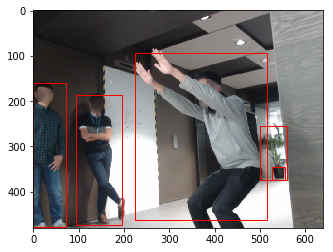

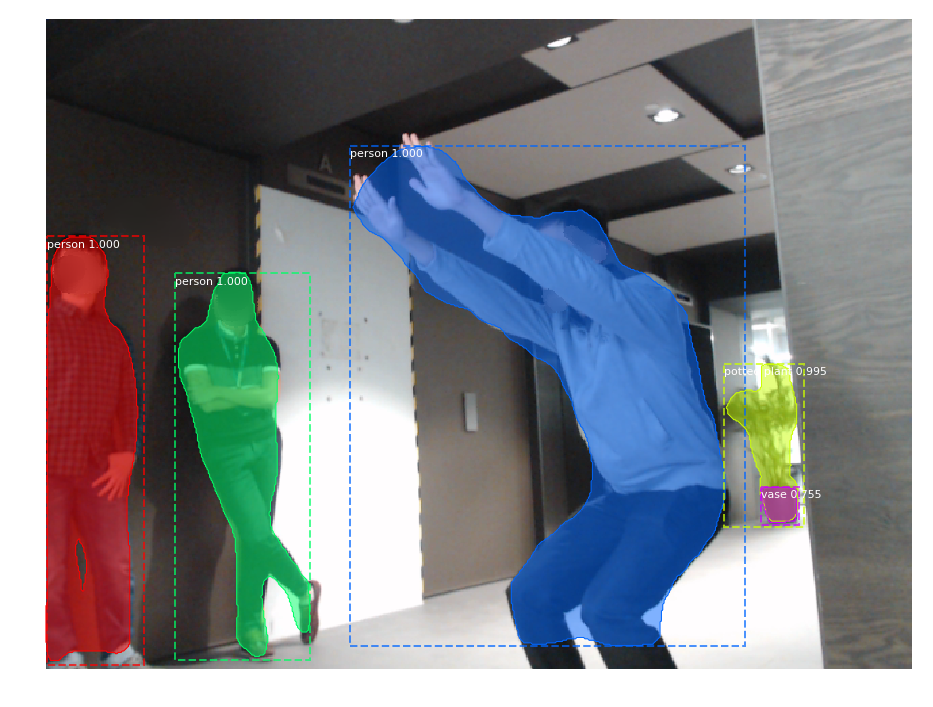

In [5]:
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from matplotlib import pyplot
from matplotlib.patches import Rectangle
# example of inference with a pre-trained coco model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from mrcnn.visualize import display_instances
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
 
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
             'bus', 'train', 'truck', 'boat', 'traffic light',
             'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
             'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
             'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
             'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
             'kite', 'baseball bat', 'baseball glove', 'skateboard',
             'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
             'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
             'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
             'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
             'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
             'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
             'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
             'teddy bear', 'hair drier', 'toothbrush']
  
# draw an image with detected objects
def draw_image_with_boxes(filename, boxes_list):
     # load the image
     data = pyplot.imread(filename)
     # plot the image
     pyplot.imshow(data)
     # get the context for drawing boxes
     ax = pyplot.gca()
     # plot each box
     for box in boxes_list:
          # get coordinates
          y1, x1, y2, x2 = box
          # calculate width and height of the box
          width, height = x2 - x1, y2 - y1
          # create the shape
          rect = Rectangle((x1, y1), width, height, fill=False, color='red')
          # draw the box
          ax.add_patch(rect)
     # show the plot
     pyplot.show()
 
# define the test configuration
class TestConfig(Config):
     NAME = "test"
     GPU_COUNT = 1
     IMAGES_PER_GPU = 1
     NUM_CLASSES = 1 + 80
 
# define the model
# change the dirs under here based on how your files are structured. Make sure they are leading to their respective files
rcnn = MaskRCNN(mode='inference', model_dir='./', config=TestConfig())
# load coco model weights
rcnn.load_weights('/content/gdrive/My Drive/Brainhack_TIL_2019_Final/model/mask_rcnn_coco.h5', by_name=True)
# load photograph
img = load_img('/content/gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/train/ChairPose/013283_102.png')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/content/gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/train/ChairPose/013283_102.png', results[0]['rois'])
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

# Testing with more pictures

This section will cover how to load in more of your own pictures and generate the mask on top of the pictures.

Things to note:

* Same as before, make sure the directories lead to the correct files.


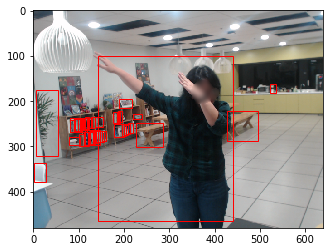

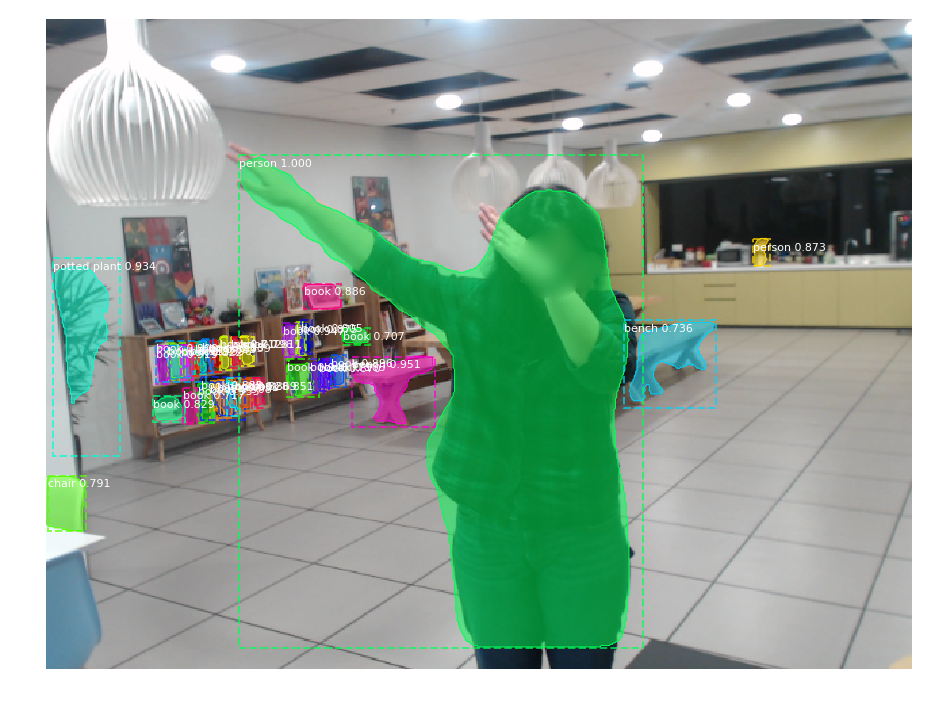

In [6]:
# make sure the directories are correct
img = load_img('/content/gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/train/Dabbing/032528_51.png')
img = img_to_array(img)
# make prediction
results = rcnn.detect([img], verbose=0)
# visualize the results
draw_image_with_boxes('/content/gdrive/My Drive/Brainhack_TIL_2019_Final/Dataset/train/Dabbing/032528_51.png', results[0]['rois'])
# get dictionary for first prediction
r = results[0]
# show photo with bounding boxes, masks, class labels and scores
display_instances(img, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

# That's it

This was as far as I got to trying to implement the model into our team's pipeline.  

For me, this was pretty exciting to try and do as this was also my first time dealing with object detection as well as working extensively with images in python.  
I hope this notebook helps you to atleast start using object detection.

Some problems I encountered specific to our challenge of identifying poses:

* Some poses only showed the hands of the humans, such as handshake and handguns(to name a few).

* Some poses also required 2 people, such as chestbump

* Some data also had people in the background which were not part of the pose.